# Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, MaxPooling1D, Dropout
from sklearn.decomposition import PCA

# Prepare data

In [2]:
# Read in dataset
df = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Take out the labels
label = df['label'].values
label

array([1, 0, 1, ..., 7, 6, 9])

In [4]:
# Drop the first column (aka the labels) and save the remaining columns as data
data = df.iloc[: , 1:].values
data.shape

(42000, 784)

In [5]:
data = np.reshape(data, (-1, 28,28, 1))
data.shape

(42000, 28, 28, 1)

# Explanation of approach

The approach of this notebook is inspired by [this article](https://medium.com/@vbm1973/classification-of-mnist-data-with-100-accuracy-d8037a43eebb). That is, instead of directly classifying each digit using their labels, we will create a representative vector for each digit. Our neural network will take in an input picture and in its last layer, will generate a vector. We then calculate the similarity score between the generated vector and the representative vectors of each digit. Then, whichever digit representative vector gives the highest similarity score will be the predicted label of our input image. 

# Create representation vectors for each digit

To create the rerepsentation vectors, we first consider the average shape of each digit. To ensure that the representative vectors are distinct enough from each other, we need to have the similarity score between each pair to be less than or equal to 0.5. 

## Get the average shape for each digit

In [6]:
digit_average_ls = []
for i in range(10):
    digit = data[label==i]
    digit_mean = np.squeeze(np.mean(digit, axis=0))
    digit_average_ls.append(digit_mean)

digit_average_ls = np.array(digit_average_ls)

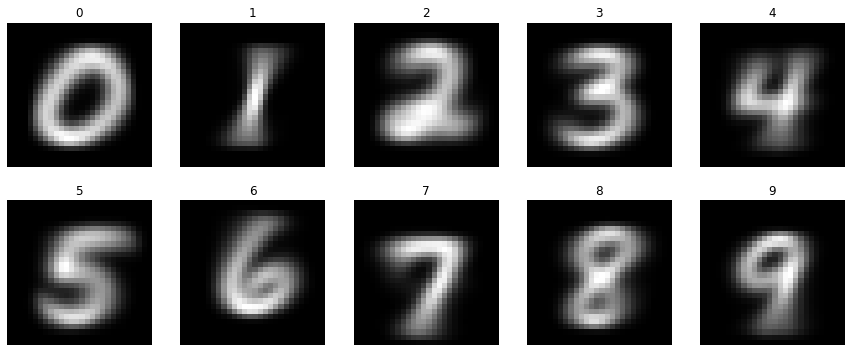

In [7]:
# Visualising the average shapes
nrows, ncols = 2,5
fig, axs = plt.subplots(2, 5, figsize=(ncols*3, nrows*3))
n = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i,j].imshow(digit_average_ls[n], cmap='gray')
        axs[i,j].axis('off')
        axs[i,j].set_title(n)
        n += 1
plt.show()

## Calculate the cosine similarities 

In [8]:
def get_cosine_similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [9]:
for i, a in enumerate(digit_average_ls):
    for j, b in enumerate(digit_average_ls):
        if i < j:
            a = a.flatten()
            b = b.flatten()
            cos_sim = get_cosine_similarity(a,b)
            if cos_sim > 0.7:
                print(i, j, cos_sim)

0 2 0.7400653081634937
0 3 0.7453187005979107
0 5 0.8406279544383235
0 6 0.7379596495322229
0 8 0.7465098928700251
1 8 0.7638262592339932
2 3 0.8069947504682508
2 4 0.7517729683790816
2 5 0.7742345778919341
2 6 0.8407964578880117
2 8 0.8586664267589967
2 9 0.7348826749766736
3 5 0.9016784192529814
3 6 0.7110344188862362
3 7 0.700910790248742
3 8 0.8757705495949757
3 9 0.7542853595785365
4 5 0.779574127045546
4 6 0.8003769450338337
4 7 0.7960182732420245
4 8 0.8123628151810484
4 9 0.9267819132897774
5 6 0.7876833674011516
5 7 0.7411338635841054
5 8 0.9124726473785157
5 9 0.8229886302568492
6 8 0.7899411440674529
6 9 0.7618184385755323
7 8 0.7683444716993767
7 9 0.8926603942774431
8 9 0.8558735139796305


The similarity scores between the average shapes are very high. Given that we consider all 28x28 pixels, there are a large black area surrounding the number that may count towards the similarity score. Therefore, we decide to apply PCA, that is compute the axes with highest variances in the dataset and reduce the dataset's dimensionality down to 25. After reducing the dimensionality of the average shapes, we obtain better similarity scores.

## Apply PCA

In [10]:
data_flatten = np.reshape(data, (data.shape[0], 28*28))
data_flatten.shape

(42000, 784)

In [11]:
pca = PCA(n_components=25)
pca.fit(data_flatten)

PCA(n_components=25)

In [12]:
digit_averages_flatten = np.reshape(digit_average_ls, (digit_average_ls.shape[0], 28*28))
digit_averages_pca = pca.transform(digit_averages_flatten)

In [13]:
for i, a in enumerate(digit_averages_pca):
    for j, b in enumerate(digit_averages_pca):
        if i < j:
            cos_sim = get_cosine_similarity(a,b)
            if cos_sim > 0.5: # there are still 2 pairs with similarity higher than 0.5
                print(i, j, cos_sim)

4 9 0.6513802688768567
7 9 0.560298214958644


# Model

## Prepare train & val sets for training

In [14]:
# change the label from digits to representative vectors
full_data_label = np.zeros((data.shape[0], digit_averages_pca.shape[1]))
for i, row in enumerate(label):
    full_data_label[i] = digit_averages_pca[row]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data, full_data_label, test_size=0.1, random_state=42)
X_val.shape

(4200, 28, 28, 1)

## Apply data augmentation using Datagen

In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=30,
        zoom_range=0.2,
        fill_mode='constant')

val_datagen = ImageDataGenerator(
        rescale=1./255)

In [17]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [18]:
## Visualise data in one batch
# for x, y in train_generator:
#     for i, each_x in enumerate(x):
#         each_x = np.squeeze(each_x)
#         plt.imshow(each_x, cmap='gray')
#         plt.show()
#     break

## Train model

Our objective is to maximise the similarity (in other words, minimise the difference) between the generated vector and the true representative vector.  Therefore, our loss function:
1. Calculates the cosine similarity between `y_true` and `y_pred`.    
2. Return `1-similarity` which is the difference between `y_true` and `y_pred`.

In [19]:
def loss_fn(y_true, y_pred):
    dot_product = tf.reduce_sum(tf.multiply(y_true, y_pred))
    norm_y_true = tf.norm(y_true)
    norm_y_pred = tf.norm(y_pred)
    similarity = dot_product / (norm_y_true * norm_y_pred)
    return 1-similarity

In [20]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                 input_shape=[28,28,1]),
    MaxPool2D(pool_size=(2,2), padding='same'),
    Dropout(rate=0.2),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), padding='same'),

    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), padding='same'),

    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(25)
])

model.compile('adam', loss = loss_fn)
batch_size = 32
history = model.fit(train_generator, steps_per_epoch = X_train.shape[0] // batch_size, 
                                   epochs=50, 
                                   validation_data = val_generator,
                                   validation_steps = X_val.shape[0] // batch_size)

2022-03-29 09:54:15.450609: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-29 09:54:15.673553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
1181/1181 [==============================] - 42s 35ms/step - loss: 0.0804 - val_loss: 0.0255
Epoch 2/50
1181/1181 [==============================] - 41s 35ms/step - loss: 0.0310 - val_loss: 0.0198
Epoch 3/50
1181/1181 [==============================] - 42s 35ms/step - loss: 0.0244 - val_loss: 0.0180
Epoch 4/50
1181/1181 [==============================] - 41s 35ms/step - loss: 0.0209 - val_loss: 0.0158
Epoch 5/50
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0188 - val_loss: 0.0155
Epoch 6/50
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0168 - val_loss: 0.0144
Epoch 7/50
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0154 - val_loss: 0.0122
Epoch 8/50
1181/1181 [==============================] - 43s 36ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 9/50
1181/1181 [==============================] - 45s 38ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 10/50
1181/1181 [==============================] - 46s 39m

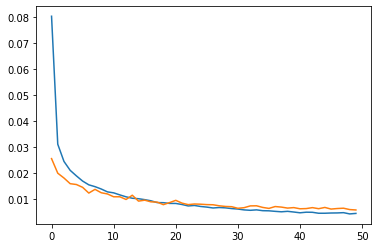

In [21]:
# Visualise result

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Test model

In [22]:
test_df = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
test_data = test_df.values
test_data = np.reshape(test_data, (-1, 28,28,1))
test_data_scaled = test_data/255.

test_pred = model.predict(test_data_scaled)

In [24]:
test_pred_label = np.zeros(test_pred.shape[0])
for i, each_pred in enumerate(test_pred):
    pred_similarities = np.array([np.abs(get_cosine_similarity(test_pred[i], centroid)) for centroid in digit_averages_pca])
    pred_label = np.argmax(pred_similarities)
    test_pred_label[i] = pred_label
test_pred_label = np.array(test_pred_label, dtype = np.int8)

In [25]:
sample_submission = pd.read_csv(r'/kaggle/input/digit-recognizer/sample_submission.csv')
image_id = sample_submission['ImageId']

result = {'ImageId' : image_id,
          'Label' : test_pred_label}

result_df = pd.DataFrame.from_dict(data=result)
result_df.to_csv('./submission.csv', index=False)

# Conclusion 

Using this approach, we achieved the best accuracy of **0.99400**. To improve this approach, we can use a different technique of creating the representative vector (such that all pairs have similarity score strictly below 0.5 or even lower). And with more extensive hyperparameter tuning, we can get better accuracy. 